In [5]:
import math
from pickletools import optimize
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



msft = yf.Ticker("MSFT")
df = msft.history(start ='2020-01-01')
df.to_csv('../CSV/msft.csv')

df = pd.read_csv('../CSV/msft.csv')

#data set for training
data = df.filter(['Close'])
dataset = data.values

#scales data into 1-0
scaler = MinMaxScaler(feature_range=(0,1))
scaler_data = scaler.fit_transform(dataset)

#training sets 
train_size = int(df.shape[0] * 0.8)
train_set = scaler_data[0: train_size, :]

x_train = []
y_train = []

for i in range(60, train_size):
    x_train.append(train_set[i-60: i, 0])
    y_train.append(train_set[i,0])



x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size = 1, epochs = 1)


419/419 [==============================] - 19s 34ms/step - loss: 0.0052


6.738417776007396


/var/folders/w_/bcbslvsd4cz_kwppplndj7gc0000gn/T/ipykernel_3461/2318488631.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


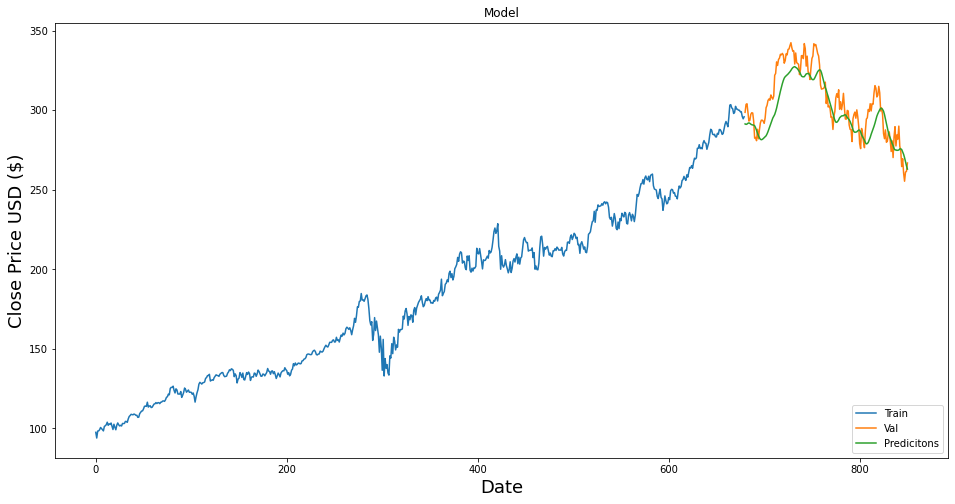

<Figure size 432x288 with 0 Axes>

In [2]:
test_data = scaler_data[train_size -60:, :]

x_test = []
y_test = dataset[train_size:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean( predictions - y_test)**2)

print(rmse)

train = data[:train_size]
valid = data[train_size:]
valid['Predictions'] = predictions

#Visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train["Close"])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predicitons'], loc = 'lower right')
plt.show()
plt.savefig("../plots/visualize.png")

In [3]:
apple = yf.Ticker("AAPL")
df = apple.history(start ='2015-01-01', end = '2016-01-01')
new_df = df.filter(['Close'])
data = new_df[-60:].values

data_scaled = scaler.transform(data)
apple_60_predictions = []

for i in range(60):
    x_test = []
    x_test.append(data_scaled)
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    pred_price = model.predict(x_test)
    data_scaled= np.concatenate((data_scaled[1:], [[pred_price[0][0]]]))
    pred_price = scaler.inverse_transform(pred_price)
    apple_60_predictions.append(pred_price[0][0])

df = apple.history(start ='2016-01-01')
print("Predictions" , "Actual")
for i in range(60):
    print(apple_60_predictions[i],"    ", df['Close'][i])

Predictions Actual
25.646795      24.185039520263672
25.63512      23.578983306884766
25.675905      23.117551803588867
25.749271      22.141881942749023
25.842337      22.25896453857422
25.94693      22.6193904876709
26.05791      22.94767189025879
26.172033      22.35767936706543
26.287354      22.846656799316406
26.402569      22.297990798950195
26.517015      22.190093994140625
26.630188      22.21993637084961
26.741852      22.107452392578125
26.851864      23.2828369140625
26.960136      22.82829475402832
27.066631      22.95455551147461
27.17138      21.446290969848633
27.274351      21.60009765625
27.375612      22.346195220947266
27.475157      22.137290954589844
27.573042      21.689634323120117
27.669262      22.118928909301758
27.763897      22.296649932861328
27.856941      21.701147079467773
27.94846      21.929655075073242
28.038446      21.92504119873047
28.126966      21.758853912353516
28.214014      21.627294540405273
28.299654      21.694225311279297
28.383896      

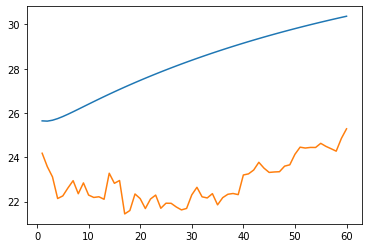

In [4]:
index = []
for i in range(60):
    index.append(i+1)

plt.plot(index, apple_60_predictions , 
        index , df['Close'][:60] )
plt.show()